### Import Libraries

In [1]:
# ===== Auto Reload =====
%load_ext autoreload
%autoreload 2

# ===== Standard Libraries =====
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import random

# ===== PyTorch =====
import torch
import torch.nn as nn
from torchdiffeq import odeint

# torchdiffeq 버전 확인
import torchdiffeq
print(f"torchdiffeq version: {torchdiffeq.__version__}")
print("")

# ===== Check Installation =====
print("="*50)
print("Environment Check")
print("="*50)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA device: {torch.cuda.get_device_name(0)}")
print(f"CUDA available: {torch.cuda.is_available()}")
print("="*50)
print("")


# ===== Your Custom Module =====
# Import from battery_ode_wrapper
from battery_ode_wrapper import*
from utils import*

print("="*50)
print("✓ All modules loaded!")
print("="*50)


torchdiffeq version: 0.2.5

Environment Check
PyTorch version: 2.5.1
CUDA device: NVIDIA RTX 3500 Ada Generation Laptop GPU
CUDA available: True

✓ All modules loaded!


### Data Import

In [2]:
import scipy.io
import os
import numpy as np
import re


# MATLAB 데이터 디렉토리 경로
data_dir = r"C:\Users\ljw76\Documents\MATLAB\LFP_SAFT\data\learning_data"

# ===== 온도 필터 설정 =====
target_temps = [25]  # 원하는 온도 리스트 (예: [25, 35] 또는 [] 이면 모든 온도)

# 디렉토리 내 모든 .mat 파일 목록 가져오기
mat_files = [f for f in os.listdir(data_dir) if f.endswith('.mat')]
print(f"Found {len(mat_files)} .mat files:")
for file in mat_files:
    print(f"  - {file}")

# 모든 파일 로드
print(f"\nLoading files with temperature filter: {target_temps if target_temps else 'All'}")
all_loaded_data = {}

for i, file in enumerate(mat_files):
    file_path = os.path.join(data_dir, file)
    print(f"Loading {i+1}/{len(mat_files)}: {file}")
    
    try:
        mat_data = scipy.io.loadmat(file_path)
        
        # 온도 추출 (파일명에서, 대문자 C만 찾기)
        temp_match = re.search(r'_(\d+)C_', file)
        file_temp = int(temp_match.group(1)) if temp_match else None
        
        # 온도 필터링
        if target_temps and (file_temp is None or file_temp not in target_temps):
            print(f"  ⚠ Skipped (temp: {file_temp}°C)")
            continue
        
        # 파일명에서 확장자 제거하여 키로 사용
        file_key = file.replace('.mat', '')
        
        # 메타데이터 키 제외한 실제 데이터만 저장
        data_keys = [key for key in mat_data.keys() if not key.startswith('__')]
        all_loaded_data[file_key] = {}
        
        for key in data_keys:
            all_loaded_data[file_key][key] = mat_data[key]
        
        print(f"  ✓ Loaded (temp: {file_temp}°C) - {len(data_keys)} data keys: {data_keys}")
        
    except Exception as e:
        print(f"  ✗ Failed to load {file}: {e}")

print(f"\nAll files loaded!")
print(f"Successfully loaded {len(all_loaded_data)} files:")
for file_key, data_dict in all_loaded_data.items():
    print(f"  {file_key}: {list(data_dict.keys())}")

# 첫 번째 파일의 데이터 구조 상세 확인
if all_loaded_data:
    first_file_key = list(all_loaded_data.keys())[0]
    first_data_key = list(all_loaded_data[first_file_key].keys())[0]
    sample_data = all_loaded_data[first_file_key][first_data_key]

    print(f"\nSample data structure from {first_file_key}[{first_data_key}]:")
    print(f"  Shape: {sample_data.shape}")
    print(f"  Type: {type(sample_data)}")
    if hasattr(sample_data, 'dtype'):
        print(f"  Dtype: {sample_data.dtype}")
        if hasattr(sample_data.dtype, 'names') and sample_data.dtype.names:
            print(f"  Field names: {sample_data.dtype.names}")



Found 16 .mat files:
  - udds1_1c_norest_25C_struct.mat
  - udds2_1c_norest_15C_struct.mat
  - udds2_1c_norest_25C_struct.mat
  - udds2_1c_norest_35C_struct.mat
  - udds2_1c_norest_45C_struct.mat
  - udds2_1c_rest_25C_struct.mat
  - udds2_1c_rest_cell0_struct.mat
  - udds3_1c_norest_25C_struct.mat
  - udds4_1c_norest_25C_struct.mat
  - udds5_1c_norest_25C_struct.mat
  - udds6_1c_norest_25C_struct.mat
  - udds7_1c_norest_15C_struct.mat
  - udds7_1c_norest_25C_struct.mat
  - udds7_1c_norest_35C_struct.mat
  - udds7_1c_norest_45C_struct.mat
  - udds8_1c_norest_25C_struct.mat

Loading files with temperature filter: [25]
Loading 1/16: udds1_1c_norest_25C_struct.mat
  ✓ Loaded (temp: 25°C) - 1 data keys: ['spme_struct']
Loading 2/16: udds2_1c_norest_15C_struct.mat
  ⚠ Skipped (temp: 15°C)
Loading 3/16: udds2_1c_norest_25C_struct.mat
  ✓ Loaded (temp: 25°C) - 1 data keys: ['spme_struct']
Loading 4/16: udds2_1c_norest_35C_struct.mat
  ⚠ Skipped (temp: 35°C)
Loading 5/16: udds2_1c_norest_45C_st

### Convert Struct to DataFrame

In [3]:
# ===== Key 선택 =====
target_keys = ["time", "Vref", "Vspme", "current", "temperature", "c_s_n_bulk", "soc_n", "ocp"]

# ===== 모든 파일 처리 =====
extracted_data = {}  # Dictionary로 저장
excluded_target = ['udds7_1c_norest_25C_struct']
excluded_data = {}
# extracted_data는 excluded_target에 들어있지 않은 것만, excluded_data는 target에 들어있는 것만 저장하도록 아래 for문 수정

print("="*60)
print("Converting all structs to DataFrames")
print("="*60)

for file_key, data_dict in all_loaded_data.items():
    print(f"\nProcessing: {file_key}")
    
    # struct 추출 (첫 번째 key)
    struct_key = list(data_dict.keys())[0]
    struct_data = data_dict[struct_key]
    
    # DataFrame 변환
    df = struct_to_dataframe(struct_data, selected_keys=target_keys)

    # 저장: excluded_target 리스트에 있으면 excluded_data에, 아니면 extracted_data에
    if file_key in excluded_target:
        excluded_data[file_key] = df
        print(f"  ✓ DataFrame created (EXCLUDED): {df.shape}")
    else:
        extracted_data[file_key] = df
        print(f"  ✓ DataFrame created: {df.shape}")
    print(f"  Columns: {list(df.columns)}")

print("\n" + "="*60)
print(f"✓ Total {len(extracted_data)} DataFrames created!")
print(f"✓ Total {len(excluded_data)} EXCLUDED DataFrames created!")
print("="*60)

# 요약
for name, df in extracted_data.items():
    print(f"  {name}: {df.shape}")

for name, df in excluded_data.items():
    print(f"  (EXCLUDED) {name}: {df.shape}")
# extracted_data는 excluded_target에 들어있지 않은 것만 들어가게끔 for문에서 처리 (아래 for문 참고!)



Converting all structs to DataFrames

Processing: udds1_1c_norest_25C_struct
Available keys in MATLAB struct:
   1. time
   2. current
   3. temperature
   4. Vout
   5. Ve
   6. Vcond
   7. eta_p
   8. eta_n
   9. Un
  10. Up
  11. ocp
  12. soc_n
  13. soc_p
  14. c_s_p_surf
  15. c_s_n_surf
  16. c_s_p_bulk
  17. c_s_n_bulk
  18. i0p
  19. k_cs
  20. alpha_cs
  21. tau_cs
  22. c_s_p_surf_tilde
  23. Dsn_eff
  24. Dsp_eff
  25. Vspme
  26. Vref
Total: 26 keys

Selected keys:
  1. time ✓
  2. Vref ✓
  3. Vspme ✓
  4. current ✓
  5. temperature ✓
  6. c_s_n_bulk ✓
  7. soc_n ✓
  8. ocp ✓

Extracting data:
------------------------------------------------------------
  ✓ time                : shape (41150, 1)      → 41150 points
  ✓ Vref                : shape (41150, 1)      → 41150 points
  ✓ Vspme               : shape (41150, 1)      → 41150 points
  ✓ current             : shape (41150, 1)      → 41150 points
  ✓ temperature         : shape (41150, 1)      → 41150 points
  ✓ c_s_n_

In [4]:
len(extracted_data)
extracted_data.keys()

dict_keys(['udds1_1c_norest_25C_struct', 'udds2_1c_norest_25C_struct', 'udds2_1c_rest_25C_struct', 'udds3_1c_norest_25C_struct', 'udds4_1c_norest_25C_struct', 'udds5_1c_norest_25C_struct', 'udds6_1c_norest_25C_struct', 'udds8_1c_norest_25C_struct'])

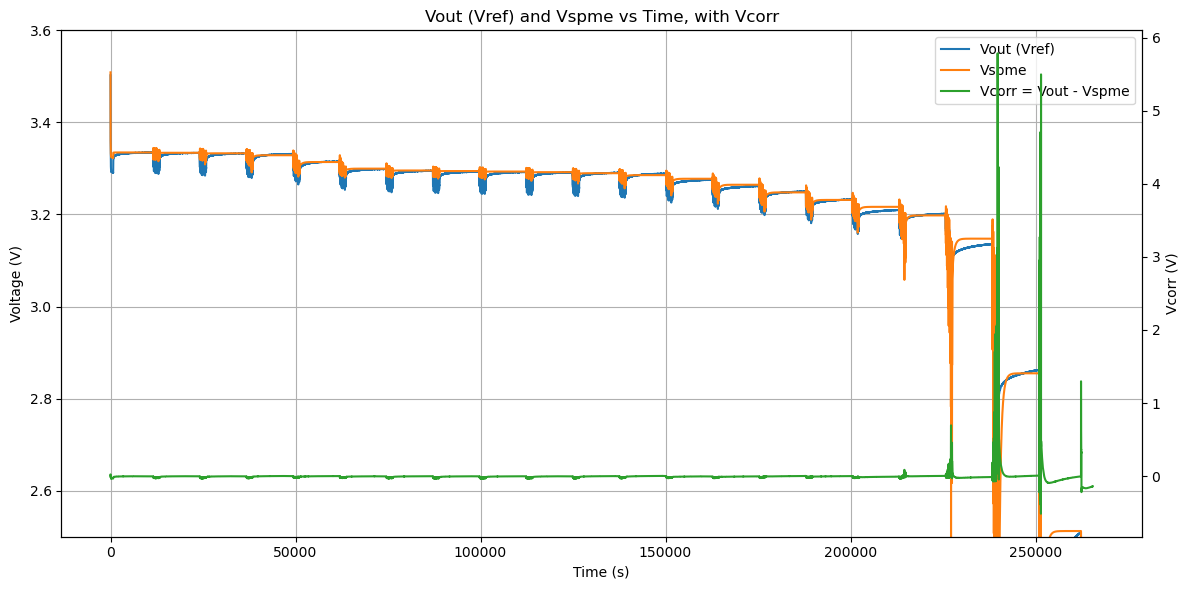

In [5]:
import matplotlib.pyplot as plt

df = extracted_data['udds2_1c_rest_25C_struct']

fig, ax1 = plt.subplots(figsize=(12,6))

# Left y-axis: Vout (Vref) and Vspme
ax1.plot(df['time'], df['Vref'], label='Vout (Vref)', color='C0')
ax1.plot(df['time'], df['Vspme'], label='Vspme', color='C1')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)')
ax1.set_ylim([2.5, 3.6])
ax1.set_title('Vout (Vref) and Vspme vs Time, with Vcorr')
ax1.grid(True)

# Right y-axis: Vcorr = Vout - Vspme
ax2 = ax1.twinx()
Vcorr = df['Vref'] - df['Vspme']
ax2.plot(df['time'], Vcorr, label='Vcorr = Vout - Vspme', color='C2')
ax2.set_ylabel('Vcorr (V)')
# Optionally, you may want to set Vcorr y-limits, e.g.:
# ax2.set_ylim([Vcorr.min(), Vcorr.max()])

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

fig.tight_layout()
plt.show()




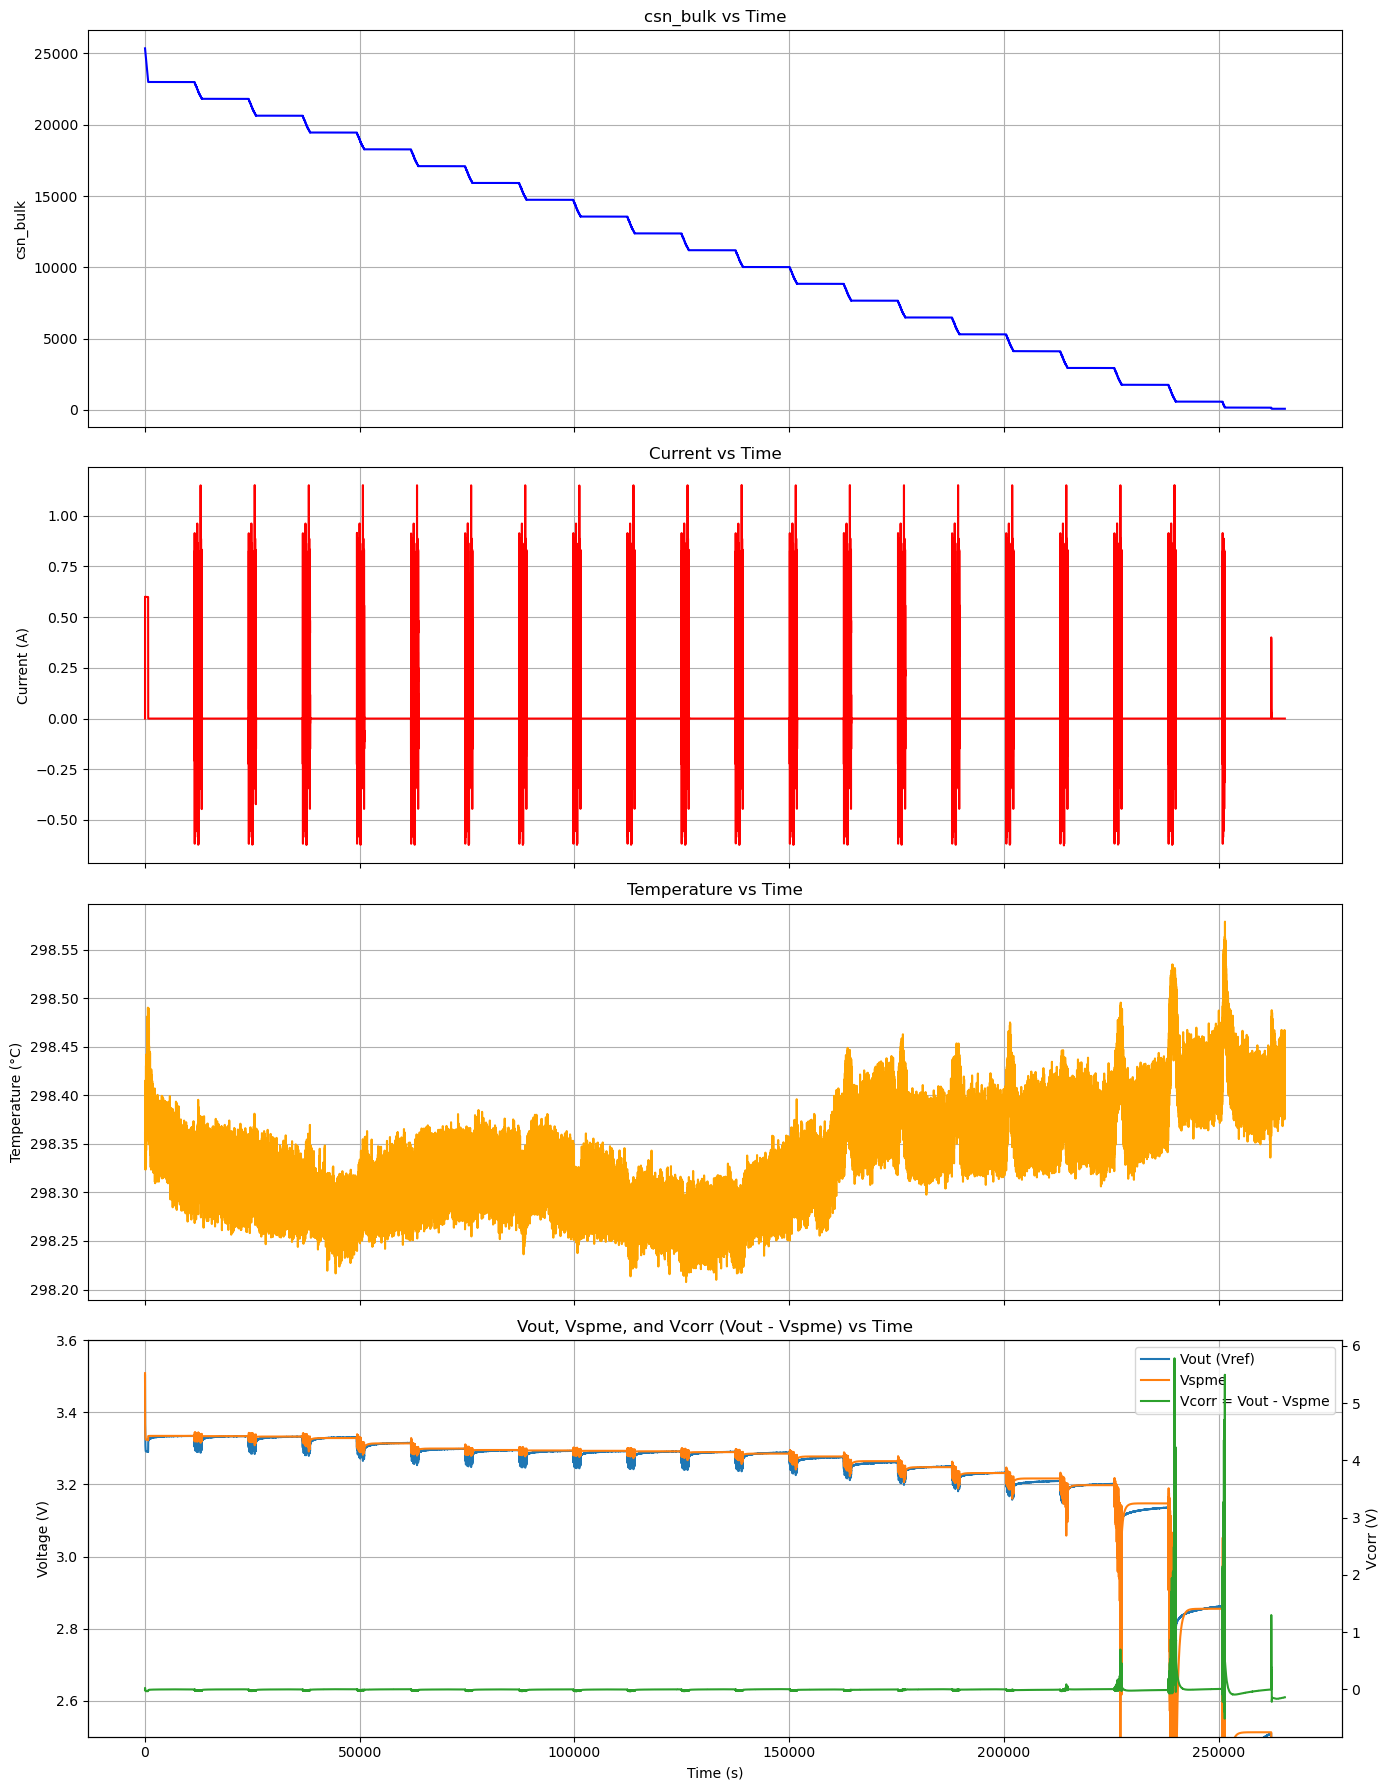

In [6]:
import matplotlib.pyplot as plt

# Assume df_sampled is already defined just as in the next cell (sampled first 10% of data)
df_vis = df

fig, axs = plt.subplots(4, 1, figsize=(14, 18), sharex=True)

# 1. csn_bulk
axs[0].plot(df_vis["time"], df_vis["c_s_n_bulk"], color="blue")
axs[0].set_ylabel("csn_bulk")
axs[0].set_title("csn_bulk vs Time")
axs[0].grid(True)

# 2. I (Current)
axs[1].plot(df_vis["time"], df_vis["current"], color="red")
axs[1].set_ylabel("Current (A)")
axs[1].set_title("Current vs Time")
axs[1].grid(True)

# 3. Temperature (T)
axs[2].plot(df_vis["time"], df_vis["temperature"], color="orange")
axs[2].set_ylabel("Temperature (°C)")
axs[2].set_title("Temperature vs Time")
axs[2].grid(True)

# 4. Vout, Vspme (left) and Vcorr (right)
ax4 = axs[3]
ax4.plot(df_vis["time"], df_vis["Vref"], label="Vout (Vref)", color="C0")
ax4.plot(df_vis["time"], df_vis["Vspme"], label="Vspme", color="C1")
ax4.set_ylabel("Voltage (V)")
ax4.set_title("Vout, Vspme, and Vcorr (Vout - Vspme) vs Time")
ax4.set_ylim([2.5, 3.6])  # Set voltage axis limits as requested
ax4.grid(True)

ax4r = ax4.twinx()
Vcorr = df_vis["Vref"] - df_vis["Vspme"]
ax4r.plot(df_vis["time"], Vcorr, label="Vcorr = Vout - Vspme", color="C2")
ax4r.set_ylabel("Vcorr (V)")

# Combine legends from both y-axes
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4r.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

axs[3].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()



soc_n exists
soc_n exists
soc_n exists
soc_n exists
soc_n exists
soc_n exists
soc_n exists


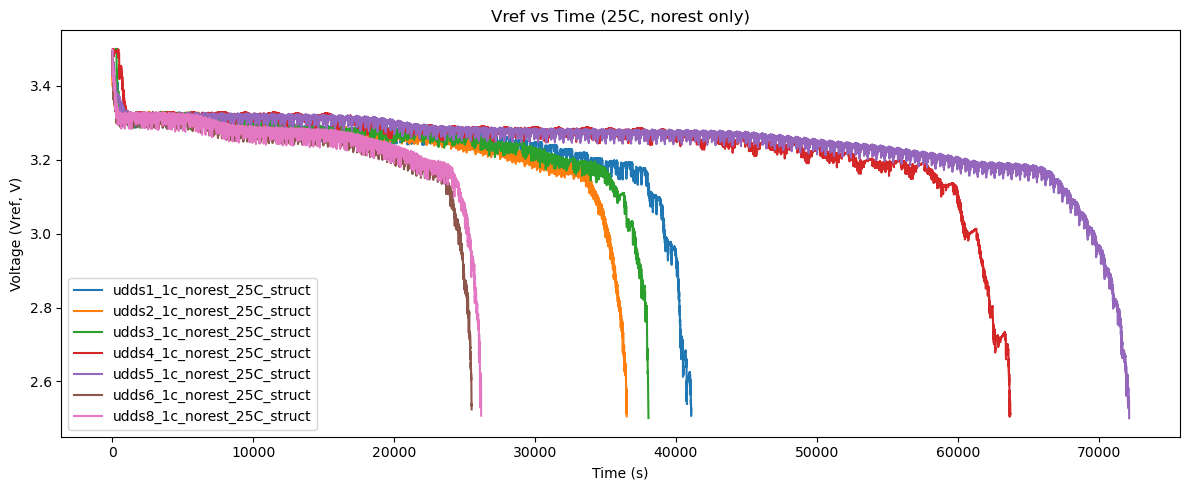


==== Processing data 1/7 ====
감지된 문제 인덱스: 11개
  중복 발견: idx=17148 (t=17120.478515625) --> idx=17149 (t=17120.478515625)
  중복 발견: idx=18220 (t=18190.5078125) --> idx=18221 (t=18190.5078125)
  중복 발견: idx=21436 (t=21400.58984375) --> idx=21437 (t=21400.58984375)
  중복 발견: idx=22508 (t=22470.619140625) --> idx=22509 (t=22470.619140625)
  중복 발견: idx=33225 (t=33170.90625) --> idx=33226 (t=33170.90625)
  중복 발견: idx=34297 (t=34240.9375) --> idx=34298 (t=34240.9375)
  중복 발견: idx=35369 (t=35310.96484375) --> idx=35370 (t=35310.96484375)
  중복 발견: idx=36441 (t=36380.9921875) --> idx=36442 (t=36380.9921875)
  중복 발견: idx=38585 (t=38521.046875) --> idx=38586 (t=38521.046875)
  중복 발견: idx=39657 (t=39591.07421875) --> idx=39658 (t=39591.07421875)
  중복 발견: idx=40729 (t=40661.1015625) --> idx=40730 (t=40661.1015625)

제거할 인덱스: [np.int64(17149), np.int64(18221), np.int64(21437), np.int64(22509), np.int64(33226), np.int64(34298), np.int64(35370), np.int64(36442), np.int64(38586), np.int64(39658)]...
원본 데이터: 

In [11]:
# Import the NEW clean implementation
from battery_ode_wrapper import train_battery_neural_ode



# 'soc_n' 값이 0.96 ~ 0.12 (96% ~ 12%) 사이인 데이터만 target_data에 저장
# target_data를 리스트(list)로 저장 (DataFrame만 담김, key는 저장하지 않음)
target_list = []
plt.figure(figsize=(12, 5))
for k, v in extracted_data.items():
    if ('25C' in k) and ('norest' in k):
        # 'soc_n' 컬럼이 있는지 확인하고, 해당 범위로 필터링
        if "soc_n" in v.columns:
            # mask = (v["soc_n"] <= 0.96) & (v["soc_n"] >= 0.12)
            mask = (v["soc_n"] <= 1.0) & (v["soc_n"] >= 0.0)
            # Add another mask: only keep values where 'Vref' >= 2.5,
            # and once 'Vref' falls below 2.5, drop the rest of the data.
            vref_mask = (v["Vref"] >= 2.5)
            # Keep only the portion up until the first time Vref < 2.5 (i.e., first False in vref_mask)
            if not vref_mask.all():
                # Index of the first occurrence where Vref < 2.5
                cutoff_idx = vref_mask.idxmin()
                # Slice up to but not including the first < 2.5
                mask = mask & vref_mask
                # Now forcibly zero out anything after cutoff_idx
                mask.iloc[cutoff_idx:] = False
            else:
                mask = mask & vref_mask

            filtered_df = v[mask].reset_index(drop=True)
            target_list.append(filtered_df)
            print("soc_n exists")
        else:
            # soc_n이 없으면 전체 데이터 저장 (혹시 모르는 데이터 구조 대비)
            target_list.append(v)
            print("soc_n does not exist")
        plt.plot(filtered_df['time'], filtered_df['Vref'], label=k)

plt.xlabel("Time (s)")
plt.ylabel("Voltage (Vref, V)")
plt.title("Vref vs Time (25C, norest only)")
plt.legend()
plt.tight_layout()
plt.show()
        

        

driving_list = remove_duplicates(target_list)

driving_list = split_df(driving_list, window_minutes=15, time_col='time', random_seed=42)

# print(f"driving_list 길이: {len(driving_list)}")
# mid = len(driving_list) // 2
# driving_list_1 = driving_list[:mid]
# driving_list_2 = driving_list[mid:]


driving_dict_list = df2dict(driving_list)

# 80:20 split for training and test
np.random.seed(42)
shuffled_indices = np.random.permutation(len(driving_dict_list))
split_idx = int(1.0 * len(driving_dict_list))
training_dict_list = [driving_dict_list[i] for i in shuffled_indices[:split_idx]]
test_dict_list = [driving_dict_list[i] for i in shuffled_indices[split_idx:]]

print(f"driving_dict_list 총 길이: {len(driving_dict_list)}")
print(f"training_dict_list 길이: {len(training_dict_list)} (80%)")
print(f"test_dict_list 길이: {len(test_dict_list)} (20%)")



#########################################################################################
 # mask = (v["soc_n"] <= 0.96) & (v["soc_n"] >= 0.12)
test_df = excluded_data['udds7_1c_norest_25C_struct']
mask = (test_df["soc_n"] <= 1.0) & (test_df["soc_n"] >= 0.0)
# Add another mask: only keep values where 'Vref' >= 2.5,
# and once 'Vref' falls below 2.5, drop the rest of the data.
vref_mask = (test_df["Vref"] >= 2.5)
# Keep only the portion up until the first time Vref < 2.5 (i.e., first False in vref_mask)

if not vref_mask.all():
    # Index of the first occurrence where Vref < 2.5
    cutoff_idx = vref_mask.idxmin()
    # Slice up to but not including the first < 2.5
    mask = mask & vref_mask
    # Now forcibly zero out anything after cutoff_idx
    mask.iloc[cutoff_idx:] = False
else:
    mask = mask & vref_mask

filtered_df = test_df[mask].reset_index(drop=True)
print("soc_n exists")

test_list = remove_duplicates([filtered_df])
test_dict_list = df2dict(test_list)


In [9]:
# Call training function
device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_epochs = 1000  # Increased from 100 to 300
# lr = 5e-4  # Rest
lr = 5e-4  # Pulse


seed = 42 # 42 : Vcorr_k, csn_k, I_k, T_k,
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True



# 여러 프로파일 배치용 (training_dict_list 사용)
ode_wrapper, history = train_battery_neural_ode_batch(
    data_list=training_dict_list,
    num_epochs=num_epochs,
    lr=lr,
    device=device,
    verbose=True,
    training_batch_size=None  # None이면 전체 한번에, 숫자면 그 개수만큼 랜덤 샘플링
)


Batch Training: 334 total profiles
Training batch size: 334 profiles per epoch
Profile lengths: [901, 902, 901, 901, 901, 902, 904, 901, 904, 902, 901, 902, 900, 901, 902, 901, 901, 901, 901, 902, 900, 901, 901, 904, 901, 901, 903, 902, 901, 900, 901, 903, 901, 901, 902, 902, 900, 902, 902, 901, 901, 901, 901, 900, 901, 901, 901, 900, 900, 901, 901, 904, 901, 902, 902, 902, 902, 900, 901, 901, 904, 902, 902, 902, 901, 902, 902, 902, 900, 904, 902, 901, 902, 902, 901, 901, 901, 901, 902, 901, 902, 901, 901, 900, 900, 901, 900, 902, 900, 900, 901, 901, 901, 900, 900, 902, 900, 903, 900, 902, 902, 902, 902, 901, 901, 902, 904, 904, 901, 901, 901, 900, 902, 901, 901, 900, 901, 901, 902, 901, 901, 901, 902, 902, 901, 900, 902, 901, 901, 902, 902, 900, 902, 901, 901, 901, 902, 901, 901, 901, 900, 903, 900, 902, 901, 904, 901, 904, 902, 901, 901, 903, 901, 901, 903, 904, 901, 902, 901, 900, 900, 902, 900, 902, 900, 904, 901, 901, 904, 902, 901, 901, 901, 902, 901, 904, 900, 900, 902, 902, 90

In [22]:
import torch

# 기존에 학습했던 best_model_batch_rmse1.83mV_6input_euler.pth 에서 가중치(state_dict)만 로드해서,
# 이어서 연달아 트레이닝이 가능하도록 한다. (train_battery_neural_ode_batch에서 ode_wrapper를 새로 만들지만, 아래에서 덮어씀)

# -- 1. 기존 모델 인스턴스 생성 (train 함수에서 생성된 것과 동일 방법, 즉 아래 두 줄 필요) --
# device는 기존 코드처럼 정해진 상태여야 함
from battery_ode_wrapper import BatteryODEWrapper
ode_wrapper = BatteryODEWrapper(device=device).to(device)

# -- 2. 기존 weight 로드 --
checkpoint_path = 'best_model_batch_rmse1.83mV_6input_euler.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)

if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    ode_wrapper.load_state_dict(checkpoint['model_state_dict'])
else:
    ode_wrapper.load_state_dict(checkpoint)
print(f"✓ Pretrained weights loaded from '{checkpoint_path}'.")

# -- 3. 이어서 트레이닝 --
# 학습 히스토리 및 optimizer 상태가 필요하면 checkpoint['optimizer_state_dict']에서 불러올 수 있지만,
# 여기서는 네트워크 가중치만 이어받아, 아래처럼 ode_wrapper를 넣어줌. (초기 가중치로 사용)
seed = 42 # 42 : Vcorr_k, csn_k, I_k, T_k,
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True


ode_wrapper, history = train_battery_neural_ode_batch(
    data_list=training_dict_list,
    num_epochs=num_epochs,
    lr=lr,
    device=device,
    verbose=True,
    training_batch_size=None,
    ode_wrapper=ode_wrapper   # ← 기존 weight를 이어받아 다시 학습
)



C:\Users\ljw76\AppData\Local\Temp\ipykernel_17024\2531932496.py:13: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



✓ Pretrained weights loaded from 'best_model_batch_rmse1.83mV_6input_euler.pth'.

Batch Training: 317 total profiles
Training batch size: 317 profiles per epoch
Profile lengths: [901, 902, 901, 901, 901, 902, 901, 901, 901, 902, 902, 901, 900, 901, 902, 901, 901, 903, 902, 901, 902, 903, 902, 901, 902, 901, 900, 901, 901, 904, 901, 902, 900, 901, 901, 901, 902, 901, 902, 902, 901, 902, 900, 901, 902, 901, 901, 902, 903, 901, 902, 901, 901, 900, 902, 901, 901, 904, 901, 901, 902, 900, 902, 901, 902, 901, 901, 901, 901, 901, 901, 900, 902, 900, 904, 900, 901, 900, 902, 901, 903, 901, 900, 901, 901, 900, 900, 901, 900, 900, 902, 901, 903, 901, 901, 902, 903, 901, 901, 902, 902, 902, 902, 902, 901, 903, 901, 902, 901, 901, 901, 901, 902, 902, 901, 901, 902, 901, 900, 900, 902, 901, 901, 901, 901, 904, 901, 904, 902, 900, 902, 901, 901, 900, 901, 901, 900, 901, 904, 901, 901, 900, 903, 901, 901, 900, 901, 901, 900, 900, 902, 901, 901, 902, 902, 900, 901, 900, 904, 902, 904, 902, 904, 900, 9

In [12]:
# Test dataset evaluation and analysis
from battery_ode_wrapper import simulate_battery_ode
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print(f"\n{'='*60}")
print(f"Evaluating {len(test_dict_list)} test profiles for analysis...")
print(f"{'='*60}\n")

# 모든 test profile에 대해 RMSE 계산
rmse_list = []
results_list = []

for i, test_dict in enumerate(test_dict_list):
    # simulate without plotting
    Vcorr_pred, Vcorr_target, Vtotal_pred, Vtotal_meas, time = simulate_battery_ode(
        ode_wrapper, test_dict, device=device, plot=False
    )
    
    # Calculate RMSE
    rmse = np.sqrt(np.mean((Vcorr_pred - Vcorr_target)**2)) * 1000  # mV
    
    # Calculate SOC range and mean current
    SOC = np.array(test_dict['SOC'])
    soc_min = np.min(SOC) * 100
    soc_max = np.max(SOC) * 100
    soc_mean = np.mean(SOC) * 100
    soc_range = soc_max - soc_min
    
    rmse_list.append(rmse)
    results_list.append({
        'idx': i,
        'rmse': rmse,
        'Vcorr_pred': Vcorr_pred,
        'Vcorr_target': Vcorr_target,
        'Vtotal_pred': Vtotal_pred,
        'Vtotal_meas': Vtotal_meas,
        'time': time,
        'data_dict': test_dict,
        'soc_min': soc_min,
        'soc_max': soc_max,
        'soc_mean': soc_mean,
        'soc_range': soc_range,
        'SOC': SOC
    })
    print(f"Profile {i:2d}: RMSE = {rmse:.2f} mV | SOC: {soc_min:.1f}-{soc_max:.1f}% | dSOC: {soc_range:.1f}%")

# Sort by RMSE
sorted_results = sorted(results_list, key=lambda x: x['rmse'])
best_result = sorted_results[0]
worst_result = sorted_results[-1]
middle_result = sorted_results[len(sorted_results)//2]

print(f"\nBest RMSE: {best_result['rmse']:.2f} mV (idx {best_result['idx']})")
print(f"Middle RMSE: {middle_result['rmse']:.2f} mV (idx {middle_result['idx']})")
print(f"Worst RMSE: {worst_result['rmse']:.2f} mV (idx {worst_result['idx']})")

# ===== Subplot 1: Voltage and Current vs Time (Best, Middle, Worst) =====
fig1 = make_subplots(
    rows=3, cols=1,
    subplot_titles=(
        f'Best: RMSE = {best_result["rmse"]:.2f} mV (idx {best_result["idx"]})',
        f'Middle: RMSE = {middle_result["rmse"]:.2f} mV (idx {middle_result["idx"]})',
        f'Worst: RMSE = {worst_result["rmse"]:.2f} mV (idx {worst_result["idx"]})'
    ),
    vertical_spacing=0.08,
    specs=[[{"secondary_y": True}], [{"secondary_y": True}], [{"secondary_y": True}]]
)

for row_idx, result in enumerate([best_result, middle_result, worst_result]):
    t_eval_np = result['time']
    Vtotal_pred = result['Vtotal_pred']
    Vtotal_meas = result['Vtotal_meas']
    I = np.array(result['data_dict']['I']*0.1)
    
    row = row_idx + 1
    
    # Voltage - Measured (left y-axis)
    fig1.add_trace(
        go.Scatter(x=t_eval_np, y=Vtotal_meas, 
                  name='Voltage (measured)', 
                  line=dict(width=2, color='red'), 
                  opacity=0.7,
                  showlegend=(row_idx == 0)),
        row=row, col=1, secondary_y=False
    )
    
    # Voltage - Predicted (left y-axis)
    fig1.add_trace(
        go.Scatter(x=t_eval_np, y=Vtotal_pred, 
                  name='Voltage (predicted)', 
                  line=dict(width=2, color='blue'), 
                  showlegend=(row_idx == 0)),
        row=row, col=1, secondary_y=False
    )
    
    # Current (right y-axis) - 더 진한 회색
    fig1.add_trace(
        go.Scatter(x=t_eval_np, y=I, 
                  name='Current', 
                  line=dict(width=1.5, color='#404040', dash='dash'),  # 진한 회색
                  opacity=0.9,
                  showlegend=(row_idx == 0)),
        row=row, col=1, secondary_y=True
    )
    
    # Update y-axis labels
    fig1.update_yaxes(title_text="Voltage (V)", secondary_y=False, row=row, col=1)
    fig1.update_yaxes(title_text="Current (A)", secondary_y=True, row=row, col=1)

fig1.update_layout(
    height=1200,
    title_text=f"Voltage and Current vs Time: Best, Middle, Worst (from {len(test_dict_list)} test profiles)",
    title_x=0.5,
    showlegend=True
)

fig1.update_xaxes(title_text="Time (s)", row=3, col=1)

fig1.show()

# ===== Subplot 2: RMSE vs Mean SOC =====
# Sort by mean SOC
sorted_by_soc_mean = sorted(results_list, key=lambda x: x['soc_mean'])
soc_mean_sorted = [r['soc_mean'] for r in sorted_by_soc_mean]
rmse_for_soc_mean = [r['rmse'] for r in sorted_by_soc_mean]

# Create single subplot
fig2 = make_subplots(
    rows=1, cols=1,
    subplot_titles=('RMSE vs Mean SOC',)
)

# Plot: RMSE vs Mean SOC
fig2.add_trace(
    go.Scatter(x=soc_mean_sorted, y=rmse_for_soc_mean, 
              name='RMSE', 
              mode='markers',
              marker=dict(size=6, color='green'),
              showlegend=False),
    row=1, col=1
)

# Update axes
fig2.update_xaxes(title_text="Mean SOC (%)", row=1, col=1)
fig2.update_yaxes(title_text="RMSE (mV)", row=1, col=1)

fig2.update_layout(
    height=500,
    title_text="RMSE vs Mean SOC",
    title_x=0.5,
    showlegend=False
)

fig2.show()

# ===== Heat Map: RMSE vs SOC and Current =====
# 모든 프로파일의 모든 시간 포인트에서 RMSE, SOC, Current 수집
all_soc = []
all_current = []
all_rmse_local = []

for result in results_list:
    t_eval_np = result['time']
    Vcorr_pred = result['Vcorr_pred']
    Vcorr_target = result['Vcorr_target']
    SOC = result['SOC']
    I = np.array(result['data_dict']['I'])
    
    # 각 시간 포인트의 로컬 RMSE 계산 (절댓값)
    rmse_local = np.abs(Vcorr_pred - Vcorr_target) * 1000  # mV
    
    all_soc.extend(SOC * 100)  # 0-100%로 변환
    all_current.extend(np.abs(I) * 0.1)  # Denormalize: normalized I * 0.1 = actual current (A)
    all_rmse_local.extend(rmse_local)

# numpy 배열로 변환
all_soc = np.array(all_soc)
all_current = np.array(all_current)
all_rmse_local = np.array(all_rmse_local)

# Binning for heatmap
soc_bins = np.linspace(all_soc.min(), all_soc.max(), 20)
current_bins = np.linspace(all_current.min(), all_current.max(), 20)

# 2D histogram 계산 (각 bin의 평균 RMSE)
heatmap_data = np.zeros((len(current_bins)-1, len(soc_bins)-1))
count_data = np.zeros((len(current_bins)-1, len(soc_bins)-1)) * 0.1

for i in range(len(all_soc)):
    soc_idx = np.digitize(all_soc[i], soc_bins) - 1
    current_idx = np.digitize(all_current[i], current_bins) - 1
    
    if 0 <= soc_idx < len(soc_bins)-1 and 0 <= current_idx < len(current_bins)-1:
        heatmap_data[current_idx, soc_idx] += all_rmse_local[i]
        count_data[current_idx, soc_idx] += 1

# 평균 계산
mask = count_data > 0
heatmap_data[mask] = heatmap_data[mask] / count_data[mask]

# Bin centers for plotting
soc_centers = (soc_bins[:-1] + soc_bins[1:]) / 2
current_centers = (current_bins[:-1] + current_bins[1:]) / 2

# Create heatmap
fig3 = go.Figure(data=go.Heatmap(
    z=heatmap_data,
    x=soc_centers,
    y=current_centers,
    colorscale='RdYlBu_r',  # Red-Yellow-Blue reversed (red = high RMSE)
    colorbar=dict(title="RMSE (mV)"),
    hovertemplate='SOC: %{x:.1f}%<br>Current: %{y:.3f}<br>RMSE: %{z:.2f} mV<extra></extra>'
))

fig3.update_layout(
    title='RMSE Heatmap: SOC vs Current',
    xaxis_title='SOC (%)',
    yaxis_title='Current (A)',
    height=600,
    width=800
)

fig3.show()



Evaluating 1 test profiles for analysis...



KeyboardInterrupt: 

In [32]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
import torch

# Assume: 
# - "extracted_data" is a list of 8 dicts (the same format as normalized batch training input)
# - "ode_wrapper" is the trained BatteryODEWrapper instance
# - All data is on CPU, and torchdiffeq/odeint is available

from torchdiffeq import odeint

# 1. Run simulations for all profiles
sim_V_preds = []
sim_times = []
sim_V_meas = []

for idx, data in enumerate(extracted_data):
    t = data['time']
    x0 = np.array([data['Y'][0]], dtype=np.float32) # Initial normalized Vcorr

    # Prepare inputs, using original (unnormalized) values for OCV, V_ref, SOC, I, T
    input_for_sim = {
        'time'   : data['time'],
        'V_ref'  : data['V_ref'] * data['Vref_std'] + data['Vref_mean'],
        'ocv'    : data['ocv'] * data['ocv_std'] + data['ocv_mean'],
        'SOC'    : data['SOC'],  # assumed already 0~1
        'I'      : data['I'] * 0.1,         # multiply by current_norm
        'T'      : data['T'] * 10 + 298.15, # denormalize; temperature_norm, temperature_mean
        'V_spme' : data['V_spme']
    }
    ode_wrapper.set_inputs(input_for_sim)
    # Run odeint, input to model is normalized if it expects so (adapt accordingly)
    t_tensor = torch.tensor(t, dtype=torch.float32)
    x0_tensor = torch.tensor(x0, dtype=torch.float32)
    y_pred = odeint(ode_wrapper, x0_tensor, t_tensor).squeeze().cpu().numpy()
    # predicted Vcorr (normalized), recover to voltage unit
    Vcorr_pred = y_pred * data['Y_std'] + data['Y_mean']            # model predicts Vcorr
    V_spme = data['V_spme']                                         # original SPME voltage (already real voltage)
    V_pred = V_spme + Vcorr_pred                                    # reconstruct predicted total voltage

    sim_V_preds.append(V_pred)
    sim_times.append(t)
    sim_V_meas.append(data['V_meas'])

# 2. Plotly interactive 8x1 subplot: pred (line), ground-truth (line)
fig = make_subplots(rows=8, cols=1, shared_xaxes=False,
                    subplot_titles=[f"Profile {i+1}" for i in range(8)],
                    vertical_spacing=0.02)

for idx in range(8):
    fig.add_trace(go.Scatter(x=sim_times[idx], y=sim_V_meas[idx], 
                             mode='lines', name=f"Measured {idx+1}",
                             line=dict(color='black'), showlegend=(idx==0)),
                  row=idx+1, col=1)
    fig.add_trace(go.Scatter(x=sim_times[idx], y=sim_V_preds[idx],
                             mode='lines', name=f"Predicted {idx+1}",
                             line=dict(color='red'), showlegend=(idx==0)),
                  row=idx+1, col=1)

fig.update_layout(
    height=2500,
    width=1100,
    title_text="Neural ODE Battery Simulation: Measured vs Predicted Voltage (All 8 Profiles)",
)

fig.update_xaxes(title_text="Time (s)")
fig.update_yaxes(title_text="Voltage (V)")

fig.show()

# 3. Calculate RMSE in 3 SOC regions for all profiles
rmse_by_region = {'[0.96,1.0]': [], '[0.12,0.96]': [], '[0,0.12]': []}

for idx in range(8):
    SOC = extracted_data[idx]['SOC']
    y_true = sim_V_meas[idx]
    y_pred = sim_V_preds[idx]
    # Region 1: [0.96, 1.0]
    mask1 = (SOC >= 0.96) & (SOC <= 1.0)
    # Region 2: [0.12, 0.96]
    mask2 = (SOC >= 0.12) & (SOC < 0.96)
    # Region 3: [0.0, 0.12]
    mask3 = (SOC >= 0.0) & (SOC < 0.12)

    def safe_rmse(y1, y2):
        if len(y1) == 0: return np.nan
        return np.sqrt(np.mean((y1 - y2) ** 2)) * 1000  # mV

    rmse1 = safe_rmse(y_true[mask1], y_pred[mask1])
    rmse2 = safe_rmse(y_true[mask2], y_pred[mask2])
    rmse3 = safe_rmse(y_true[mask3], y_pred[mask3])

    rmse_by_region['[0.96,1.0]'].append(rmse1)
    rmse_by_region['[0.12,0.96]'].append(rmse2)
    rmse_by_region['[0,0.12]'].append(rmse3)

# 4. Print RMSEs
print("[RMSE by region for each profile] (in mV):")
for region in ['[0.96,1.0]', '[0.12,0.96]', '[0,0.12]']:
    vals = rmse_by_region[region]
    # also print mean (ignoring nan)
    avg = np.nanmean(vals)
    slist = ", ".join([f"{v:.2f}" if not np.isnan(v) else "NaN" for v in vals])
    print(f"{region} : [{slist}]  mean={avg:.2f} mV")



TypeError: string indices must be integers, not 'str'

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import numpy as np
import torch

# Normalization constants (copied from utils.py: df2dict)
current_norm = 0.1
temperature_norm = 10
temperature_mean = 298.15
ocv_mean = 3.28
ocv_std = 0.04
Vref_mean = 3.28 - 0.015
Vref_std = 0.04
Y_mean = -0.015
Y_std = 0.004

# Neural ODE model은 'ode_wrapper' 인스턴스 사용, device 자동 할당
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ode_wrapper.eval()  # 추론 모드

rmse_by_region_all = []

def safe_rmse(y1, y2):
    y1 = np.array(y1)
    y2 = np.array(y2)
    mask = ~np.isnan(y1) & ~np.isnan(y2)
    if np.sum(mask) == 0:
        return np.nan
    return np.sqrt(np.mean((y1[mask] - y2[mask]) ** 2)) * 1000  # mV

for idx, df in enumerate(test_list):
    # 데이터 준비 (벡터 numpy array로 변환)
    t = np.array(df['time'], dtype=np.float32)
    Vref = np.array(df['Vref'], dtype=np.float32)
    Vspme = np.array(df['Vspme'], dtype=np.float32)
    SOC = np.array(df['soc_n'], dtype=np.float32)
    I = np.array(df['current'], dtype=np.float32)
    T = np.array(df['temperature'], dtype=np.float32)
    ocv = np.array(df['ocp'], dtype=np.float32)

    # Input normalization
    SOC_input = SOC  # already normalized (0~1)
    I_input = I / current_norm
    T_input = (T - temperature_mean) / temperature_norm
    Vref_input = (Vref - Vref_mean) / Vref_std
    ocv_input = (ocv - ocv_mean) / ocv_std

    # dt 계산 (각 time index마다 다음 step까지 diff, 마지막은 dt=평균)
    dt_arr = np.diff(t, prepend=t[0])
    dt_arr[0] = dt_arr[1] if len(dt_arr) > 1 else 1.0

    # 초기값(Vcorr)만 원본 데이터에서 사용 (정규화)
    Vcorr_true_raw = Vref - Vspme
    Vcorr_pred_norm = np.zeros_like(t, dtype=np.float32)
    Vcorr_pred_norm[0] = (Vcorr_true_raw[0] - Y_mean) / Y_std

    # Neural ODE Recurrent rollout (Euler method)
    with torch.no_grad():
        for k in range(len(t) - 1):
            # Prepare NN input [V_ref(norm), ocv(norm), Vcorr(norm), SOC, I(norm), T(norm)]
            nn_input = np.array([
                Vref_input[k],
                ocv_input[k],
                Vcorr_pred_norm[k],
                SOC_input[k],
                I_input[k],
                T_input[k]
            ], dtype=np.float32)
            nn_input_torch = torch.from_numpy(nn_input).float().unsqueeze(0).to(device)  # shape: (1,6)
            dVcorr_dt = ode_wrapper.net(nn_input_torch).cpu().item()
            # Euler step: Vcorr_next = Vcorr_now + dt * dVcorr/dt
            Vcorr_pred_norm[k+1] = Vcorr_pred_norm[k] + dt_arr[k+1] * dVcorr_dt

    # 역정규화 : pred,  measurement 동기화
    Vcorr_pred_raw = Vcorr_pred_norm * Y_std + Y_mean

    y_true = Vref
    y_pred = Vspme + Vcorr_pred_raw

    # 3개 구간 mask
    mask1 = (SOC >= 0.96) & (SOC <= 1.0)
    mask2 = (SOC >= 0.12) & (SOC < 0.96)
    mask3 = (SOC >= 0.0) & (SOC < 0.12)

    rmse1 = safe_rmse(y_true[mask1], y_pred[mask1])
    rmse2 = safe_rmse(y_true[mask2], y_pred[mask2])
    rmse3 = safe_rmse(y_true[mask3], y_pred[mask3])
    rmse_by_region_all.append((rmse1, rmse2, rmse3))

    # --- Plot each profile with plotly ---
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=t, y=Vref, name='Vref (Measured)', line=dict(color='royalblue')
    ))
    fig.add_trace(go.Scatter(
        x=t, y=y_pred, name='Vspme+Vcorr_pred (Predicted)', line=dict(color='firebrick')
    ))
    # Vspme Plot은 제거함!

    # RMSE by region annotation: legend 위쪽에 annotation
    region_txt = (
        f"<b>RMSE by SOC region [mV]</b><br>"
        f"[0.96,1.0]: {rmse1:.2f}<br>"
        f"[0.12,0.96]: {rmse2:.2f}<br>"
        f"[0,0.12]: {rmse3:.2f}<br>"
    )

    # 레전드 오른쪽 위 = (x=1.0, y=1.0) 조금 왼쪽/아래로
    fig.add_annotation(
        xref='paper', yref='paper',
        x=0.98, y=0.99,
        text=region_txt,
        showarrow=False,
        align="left",
        borderpad=4,
        bordercolor="gray",
        bgcolor="rgba(255,255,255,0.90)",
        font=dict(size=12),
    )

    fig.update_layout(
        title=f"Profile {idx+1}: Neural ODE Battery Simulation (Measured vs Predicted)",
        xaxis_title="Time (s)",
        yaxis_title="Voltage (V)",
        legend=dict(x=0.01, y=0.99, borderwidth=0, bgcolor="rgba(0,0,0,0)"),  # 왼쪽 위
        margin=dict(t=60, l=60, r=20, b=40),
        height=400,
        width=800,
        template="simple_white",
        yaxis=dict(range=[2.5, 3.6]),
    )
    fig.show()

print("[RMSE by region for each profile] (in mV):")
for idx, (rmse1, rmse2, rmse3) in enumerate(rmse_by_region_all):
    print(f"Profile {idx+1:2d}: [0.96,1.0] = {rmse1:.2f}, [0.12,0.96] = {rmse2:.2f}, [0,0.12] = {rmse3:.2f}")

print("\n[Note] If RMSE is too small/zero, check if you are using ground truth Vcorr for rollout. Only use true value at t=0, all subsequent Vcorr(k) must use previous ODE-predicted value.")


[RMSE by region for each profile] (in mV):
Profile  1: [0.96,1.0] = 8.27, [0.12,0.96] = 4.43, [0,0.12] = 726.91

[Note] If RMSE is too small/zero, check if you are using ground truth Vcorr for rollout. Only use true value at t=0, all subsequent Vcorr(k) must use previous ODE-predicted value.


In [41]:
df = extracted_data['udds1_1c_norest_25C_struct']
df

,time,Vref,Vspme,current,temperature,c_s_n_bulk,soc_n,ocp,Vcorr
0,0.0000,3.4853,3.508726,-0.0000,298.6530,25360.650000,1.000000,3.508726,-0.023426
1,0.0075,3.4853,3.508726,0.0000,298.6532,25360.650000,1.000000,3.508726,-0.023426
2,1.0492,3.4858,3.508497,0.0018,298.6767,25360.644841,1.000000,3.508608,-0.022697
3,2.0501,3.4855,3.508458,0.0019,298.6433,25360.634653,0.999999,3.508576,-0.022958
4,3.0505,3.4854,3.508468,0.0016,298.6711,25360.625018,0.999999,3.508568,-0.023068
...,...,...,...,...,...,...,...,...,...
41145,41075.1291,2.5287,2.514740,-0.0455,298.6503,261.842931,0.008413,1.969315,0.013960
41146,41076.1296,2.5296,2.403154,-0.0163,298.6461,262.010398,0.008420,1.910519,0.126446
41147,41077.1306,2.5063,-0.177637,0.4250,298.6571,260.885512,0.008375,0.483940,2.683937
41148,41078.1297,2.5155,1.069093,0.0885,298.6713,259.469274,0.008320,1.649645,1.446407


In [40]:
type(extracted_data)

dict

In [44]:
target_list[1]

,time,Vref,Vspme,current,temperature,c_s_n_bulk,soc_n,ocp,Vcorr
0,0.0000,3.4760,3.508726,0.0000,298.6784,25360.650000,1.000000,3.508726,-0.032726
1,1.0353,3.4762,3.508497,0.0018,298.6428,25360.644871,1.000000,3.508608,-0.032297
2,2.0344,3.4763,3.508572,0.0010,298.6540,25360.637166,0.999999,3.508634,-0.032272
3,3.0343,3.4765,3.508558,0.0010,298.6405,25360.631658,0.999999,3.508620,-0.032058
4,4.0344,3.4763,3.508455,0.0017,298.6314,25360.624226,0.999999,3.508561,-0.032155
...,...,...,...,...,...,...,...,...,...
36542,36502.5187,2.5364,-1.452823,0.5591,298.7622,347.168889,0.011784,-0.776854,3.989223
36543,36503.5181,2.5312,-0.839432,0.4543,298.7437,344.390670,0.011675,-0.174094,3.370632
36544,36504.5186,2.5250,-0.689453,0.4229,298.7667,341.970032,0.011579,-0.027647,3.214453
36545,36505.5181,2.5155,-0.911017,0.4560,298.7636,339.535938,0.011483,-0.245190,3.426517
